In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_excel('../data/main.xlsx', header=0)
df.head()

,country,population,happiness,bad_conditions,culture,health_estimate,commute,education_underachievements,minimum_wage,unmet_medical_needs
0,Austria,8858775,39.7,10.4,18.40,71.4,39.6,21.69,1500.00,0.1
1,Belgium,11467923,21.2,18.0,20.55,74.5,48.2,19.80,1501.82,1.8
2,Bulgaria,7000039,9.5,13.0,6.68,66.4,33.4,40.46,184.07,1.9
3,Croatia,4076246,16.5,11.2,9.02,60.7,37.9,25.02,395.61,1.4
4,Cyprus,875898,22.4,30.2,8.85,76.3,22.4,39.97,870.00,1.4


Na początku sprobujmy użyć tylko najbardziej skorelowanych cech. Zgodnie z przyjętą podczas analizy eksploracyjnej zasadą, cechą dla której będziemy robili predykcję, jest cecha ```happiness```.

In [3]:
df.corr()['happiness'].sort_values()

education_underachievements   -0.556358
bad_conditions                -0.446700
unmet_medical_needs           -0.253131
population                    -0.090328
commute                        0.360781
health_estimate                0.489360
culture                        0.547529
minimum_wage                   0.616758
happiness                      1.000000
Name: happiness, dtype: float64

In [4]:
features = ['education_underachievements', 'bad_conditions', 'health_estimate', 'culture', 'minimum_wage']
# features = [f for f in df.columns if f not in ['country', 'happiness']]
target_feature = ['happiness']
features

['education_underachievements',
 'bad_conditions',
 'health_estimate',
 'culture',
 'minimum_wage']

Funkcja dla podziału na zbiór treningowy i testowy:

In [5]:
def split(dataframe):
    X_train, X_test, y_train, y_test = train_test_split(dataframe[features], dataframe[target_feature],
                                                    test_size=0.3, random_state=43)
    y_train = y_train.iloc[:,0].ravel()
    y_test = y_test.iloc[:,0].ravel()

    plt.figure(figsize=(10,7), dpi=100)
    for i, x_feature in enumerate(['education_underachievements', 'health_estimate', 'culture', 'minimum_wage']):
        plt.subplot(2, 2, i+1)
        plt.scatter(X_train[x_feature], y_train, label='Training Set')
        plt.scatter(X_test[x_feature], y_test, color='red', label='Testing Set')
        plt.xlabel(x_feature)
        plt.ylabel('happiness')
        plt.legend()
    return X_train, X_test, y_train, y_test

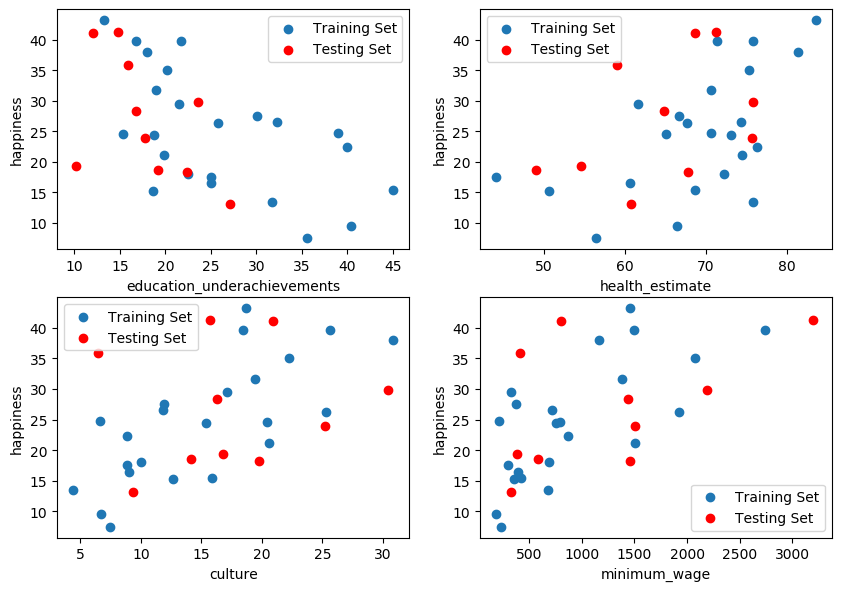

In [6]:
X_train, X_test, y_train, y_test = split(df)

Tę funkcję będziemy używali do wyznaczania tego, jak dobrze działają różne modele regresji.

In [7]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import accuracy_score

def check_regressor(reg_model, X_train, X_test, y_train, y_test, graph=True, verbose=True, tree=False, x_feature = 'minimum_wage'):
    
    reg_model.fit(X_train, y_train)
    
    y_dopas = reg_model.predict(X_train)
    y_pred = reg_model.predict(X_test)
    
    
    score = explained_variance_score(y_test, y_pred)
#     score = accuracy_score(y_test, y_pred)
#     score = reg_model.score(X_test, y_test)

    if verbose:
        print(reg_model.__class__.__name__, score)
    
    if graph:
        
        plt.figure(figsize=(11,3), dpi=100)

        plt.subplot(1, 2, 1)
        plt.scatter(sorted(X_train[x_feature]), y_train, color='blue', label='Training Set')
        plt.scatter(sorted(X_train[x_feature]), y_dopas, color='black', label='Prediction')
        plt.plot(sorted(X_train[x_feature]), y_dopas, color='black')
        plt.xlabel(x_feature)
        plt.ylabel('happiness')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.scatter(sorted(X_test[x_feature]), y_test, color='red', label='Testing Set')
        plt.scatter(sorted(X_test[x_feature]), y_pred, color='black', label='Prediction')
        plt.plot(sorted(X_test[x_feature]), y_pred, color='black')
        plt.xlabel(x_feature)
        plt.ylabel('happiness')
        plt.legend()

    if tree:
        print(reg_model.n_features_)
        print(reg_model.feature_importances_)
        print(reg_model.max_features_)
        print(reg_model.n_outputs_)
        
    return score

Jak widać z wykresów powyżej, zebrane dane praktycznie nie układają się pięknie według trendu, więc predykcja za pomocą regresji może być nieco skomplikowanym zadaniem. Nie pomaga też i ilość danych: tylko 33 próbki na 5 dobrze skorelowanych cech.

Metody które zostałe użyte:
* Zwykła regresja liniowa (porażka - bardzo mało danych).
* Regresja wieloraka z potęgowaniem każdej z cech (porażka - za szybko rośnie wariancja).
* Metody z regularyzacją: Ridge i Lasso regression (score nie więcej za 0.3).
* Metody z regularyzacją z potęgowaniem
* Ridge i Lasso z walidacją krzyżową
* Drzewa decyzyjne i lase losowe
* PCA (Linear, Ridge, Lasso)

## Linear Regression

LinearRegression 0.12976534989194632


0.12976534989194632

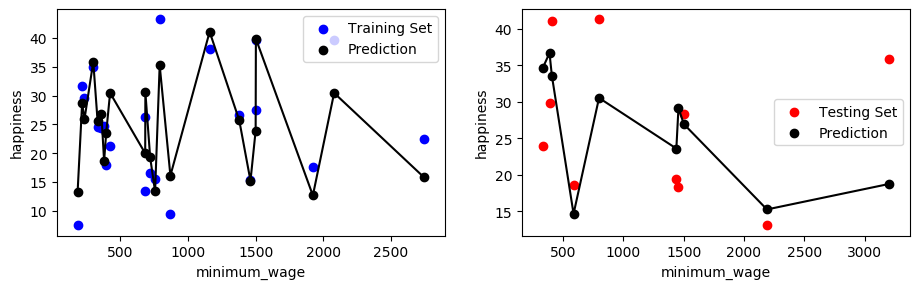

In [8]:
from sklearn.linear_model import LinearRegression
check_regressor(LinearRegression(), X_train, X_test, y_train, y_test)

Mało danych, więc obserwujemy dużą wariancję modelu.

## Linear Regression z potęgowaniem cech

Idea polega na zastosowaniu regresji wielomianowej w przypadku wielu cech. Poniższa funkcja buduje nową ramkę danych poprzez dodawanie kolejnych potęg każdej z kolumn.

In [9]:
def produce_matrix(dataframe, n):
    d = dataframe.copy()
    d_col = d.columns
    for st in range(2, n+1):
        for fea in d_col:
            d[f'{fea}^{st}'] = d[fea]**st
#     d.insert(0, 'intercept', 1.0)
    return d

In [10]:
k = 2
X_train_2 = produce_matrix(X_train, k)
X_test_2 = produce_matrix(X_test, k)

LinearRegression -0.6015916652780093


-0.6015916652780093

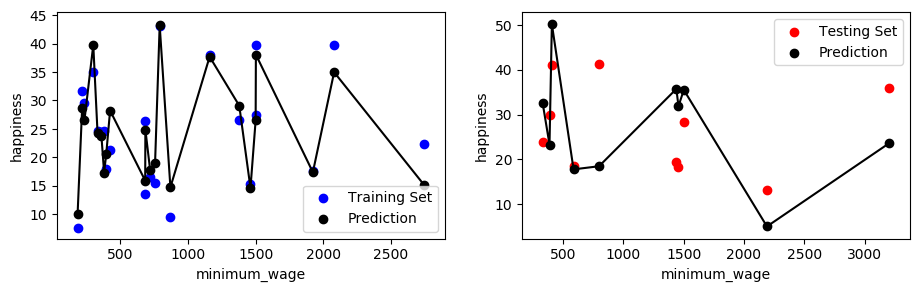

In [11]:
check_regressor(LinearRegression(), X_train_2, X_test_2, y_train, y_test)

Dobrze widać problem: dodawanie dużej ilości cech spowodowało drastyczny wzrost wariancji modelu - model za mocno dopasowuje się do danych treningowych i nie wykrywa trendu. Kolejny pomysł: użyć regularyzacji.

## Ridge

In [12]:
from sklearn.linear_model import Ridge

Ridge 0.30505435804728165


0.30505435804728165

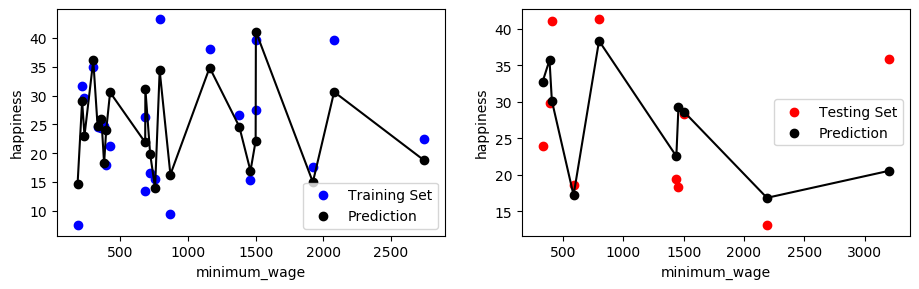

In [13]:
ridge = Ridge(alpha=640.1)
check_regressor(ridge, X_train, X_test, y_train, y_test, graph=True)

Już trochę lepiej, sprobójmy dobrać najlepszy parametr alpha:

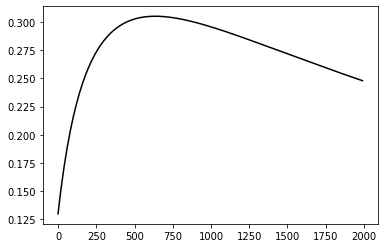

In [14]:
alphas = {}
for i in np.arange(0.1, 2000, 10):
    ridge = Ridge(alpha=i)
    s = check_regressor(ridge, X_train, X_test, y_train, y_test, graph=False, verbose=False)
    alphas[s] = i
len(alphas)
plt.plot(list(np.arange(0.1, 2000, 10)), list(alphas.keys()), color='black')

In [15]:
print(max(alphas), alphas[max(alphas)])
best_ridge = alphas[max(alphas)]

0.30505435804728165 640.1


## Lasso

In [16]:
from sklearn.linear_model import Lasso

Lasso 0.28014712641080064


0.28014712641080064

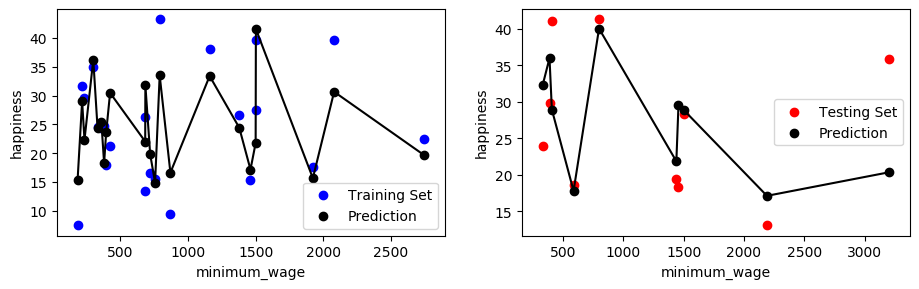

In [17]:
lasso = Lasso(alpha=8.1)
check_regressor(lasso, X_train, X_test, y_train, y_test, graph=True)

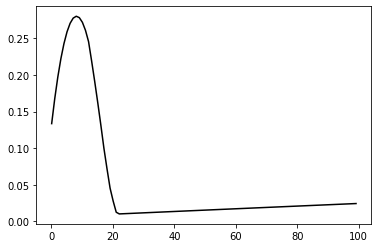

In [18]:
alphas = {}
rng = np.arange(0.1, 100, 1)
for i in rng:
    lasso = Lasso(alpha=i)
    s = check_regressor(lasso, X_train, X_test, y_train, y_test, graph=False, verbose=False)
    alphas[s] = i
len(alphas)
plt.plot(list(rng), list(alphas.keys()), color='black')

In [19]:
print(max(alphas), alphas[max(alphas)])
best_lasso = alphas[max(alphas)]

0.28014712641080064 8.1


Wniosek: regularyzacja nie daje wyników lepszych od score=0.3

## Regularyzacja z potęgowaniem: Ridge i Lasso

In [20]:
k = 3
X_train_2 = produce_matrix(X_train, k)
X_test_2 = produce_matrix(X_test, k)

Ridge -0.10105990338663329


/home/mccastles/miniconda3/envs/data/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.25557e-18): result may not be accurate.
  overwrite_a=True).T


-0.10105990338663329

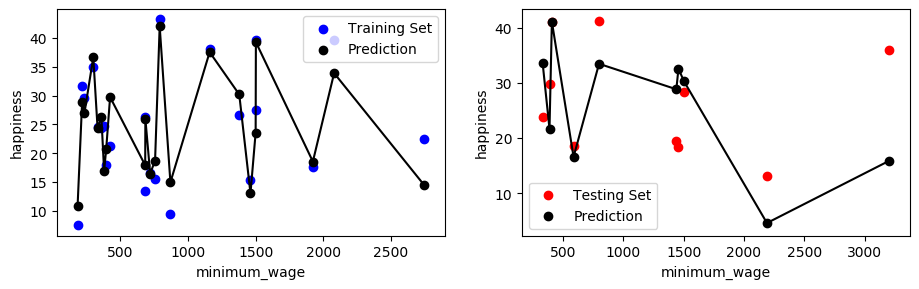

In [21]:
ridge = Ridge(alpha=640.1)
check_regressor(ridge, X_train_2, X_test_2, y_train, y_test, graph=True)

Lasso 0.01482713310535222


/home/mccastles/miniconda3/envs/data/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225.71469246623025, tolerance: 0.2167884660869566
  positive)


0.01482713310535222

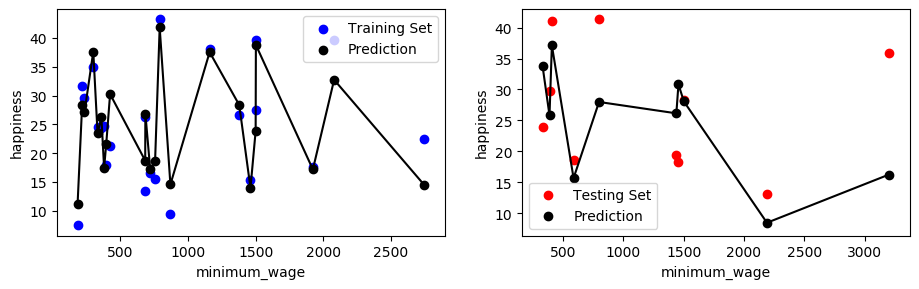

In [22]:
lasso = Lasso(alpha=8.1)
check_regressor(lasso, X_train_2, X_test_2, y_train, y_test, graph=True)

## Ridge/Lasso with Cross-Validation

In [23]:
from sklearn.linear_model import LassoCV, RidgeCV

RidgeCV 0.1415916192586637


0.1415916192586637

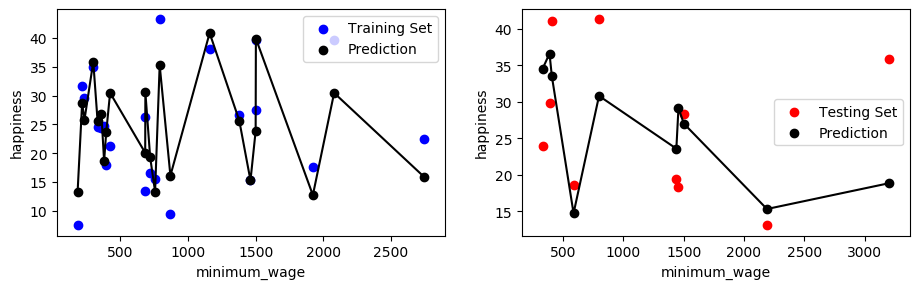

In [24]:
check_regressor(RidgeCV(cv=4), X_train, X_test, y_train, y_test, graph=True)

LassoCV 0.2510143928092212


0.2510143928092212

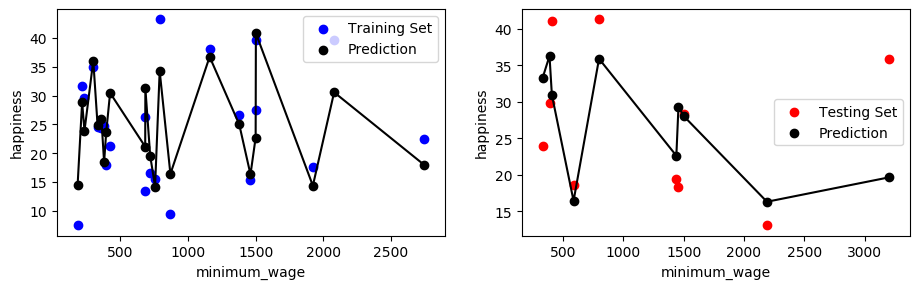

In [25]:
check_regressor(LassoCV(cv=4), X_train, X_test, y_train, y_test, graph=True)

In [26]:
# check_regressor(RidgeCV(cv=7), X_train_2, X_test_2, y_train, y_test, graph=True)

LassoCV 0.14181792382245495


0.14181792382245495

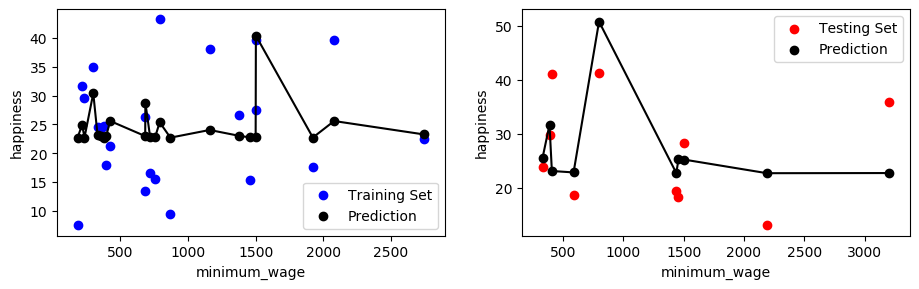

In [27]:
check_regressor(LassoCV(cv=4), X_train_2, X_test_2, y_train, y_test, graph=True)

## Decision Tree Regressor

In [28]:
from sklearn.tree import DecisionTreeRegressor

DecisionTreeRegressor -0.8887592992620388
5
[0.00158911 0.2826099  0.09378292 0.61914046 0.00287761]
5
1


-0.8887592992620388

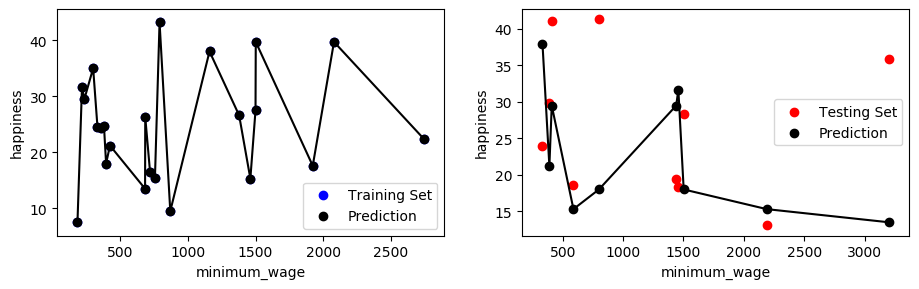

In [29]:
check_regressor(DecisionTreeRegressor(), X_train, X_test, y_train, y_test, graph=True, tree=True)

## Random Forest Regressor

In [30]:
from sklearn.ensemble import RandomForestRegressor

RandomForestRegressor 0.20107670344790862


0.20107670344790862

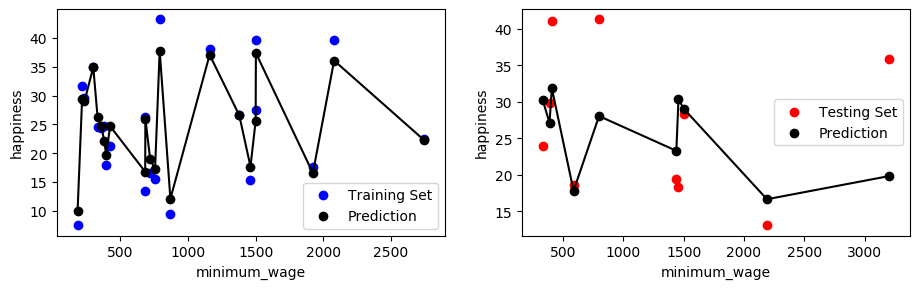

In [31]:
model = RandomForestRegressor(n_estimators=100, max_leaf_nodes=16)
check_regressor(model, X_train, X_test, y_train, y_test, graph=True)

## Principal Component Analysis

In [32]:
from sklearn.decomposition import PCA

In [33]:
n_comp = 4
pca = PCA(n_components=n_comp)
X2D = pca.fit_transform(df[features])

dff = pd.DataFrame(X2D, columns=[f'PC{i}' for i in range(1, n_comp+1)])
dff[target_feature] = df[target_feature]
dff.head(2)

X_train, X_test, y_train, y_test = train_test_split(dff.iloc[:,:n_comp], dff.iloc[:,-1],
                                                    test_size=0.3, random_state=43)

In [34]:
def reg_pc(model):
    for i in range(1, n_comp+1):
        check_regressor(model, X_train, X_test, y_train, y_test, graph=True, x_feature=f'PC{i}')

## Linear Regression PCA

LinearRegression 0.33648764173946777
LinearRegression 0.33648764173946777
LinearRegression 0.33648764173946777
LinearRegression 0.33648764173946777


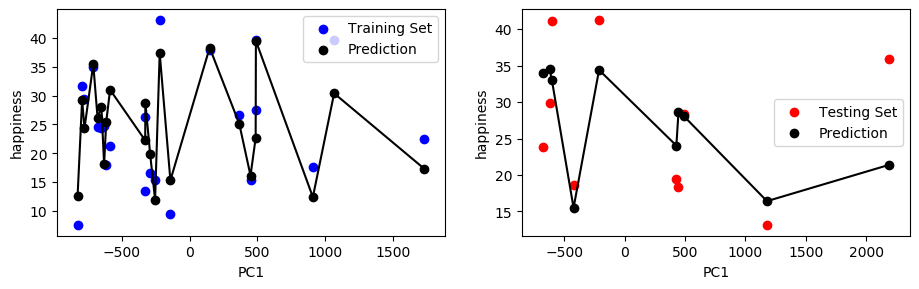

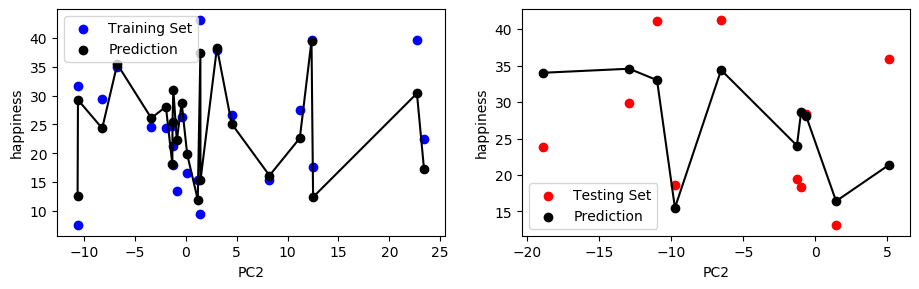

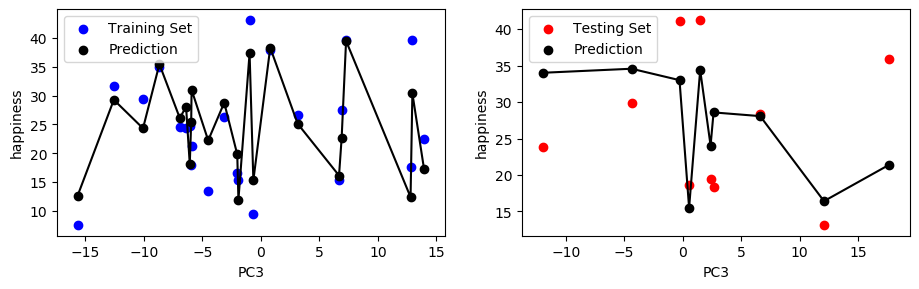

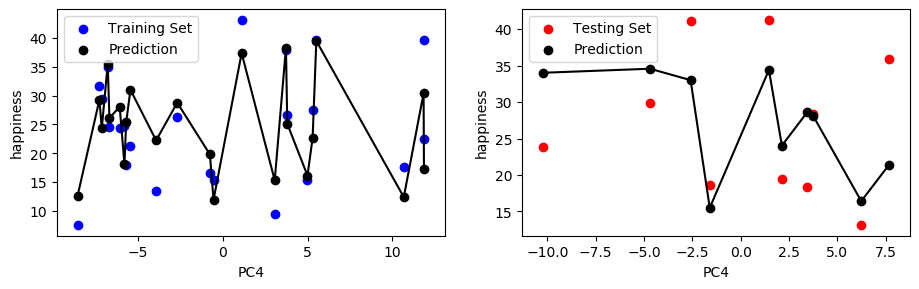

In [35]:
reg_pc(LinearRegression())

## Ridge Regression PCA

Ridge 0.3366215378061973
Ridge 0.3366215378061973
Ridge 0.3366215378061973
Ridge 0.3366215378061973


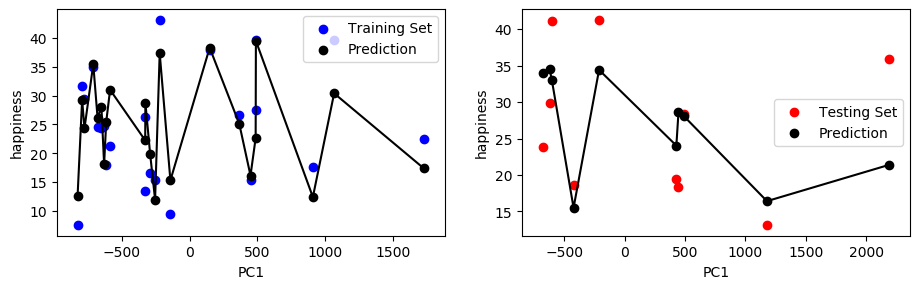

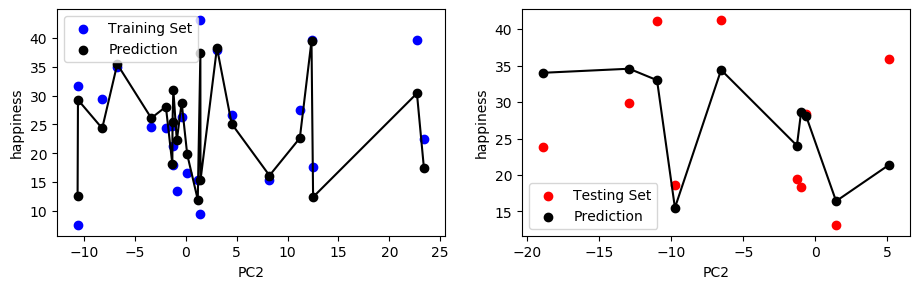

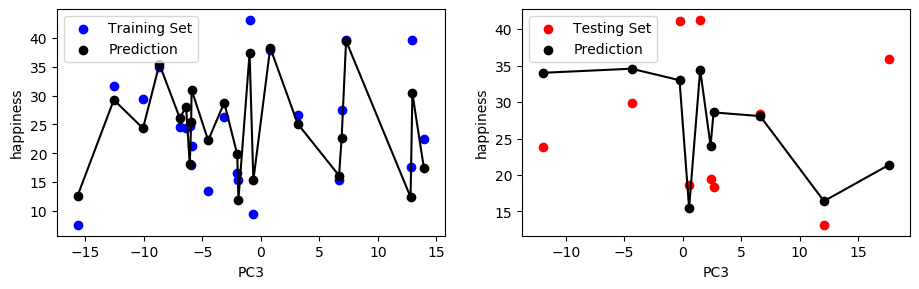

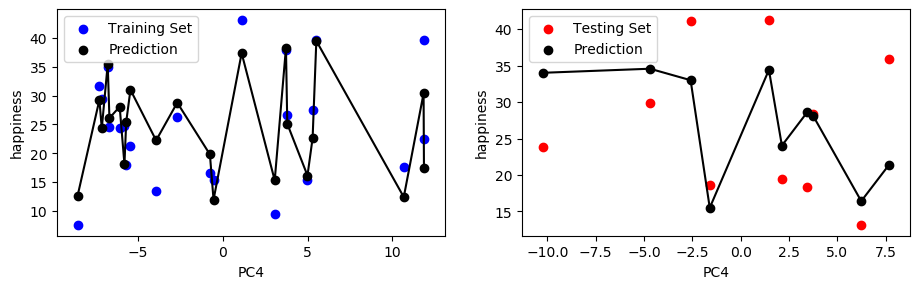

In [36]:
reg_pc(Ridge())

## Lasso Regression PCA

Lasso 0.3429455203317018
Lasso 0.3429455203317018
Lasso 0.3429455203317018
Lasso 0.3429455203317018


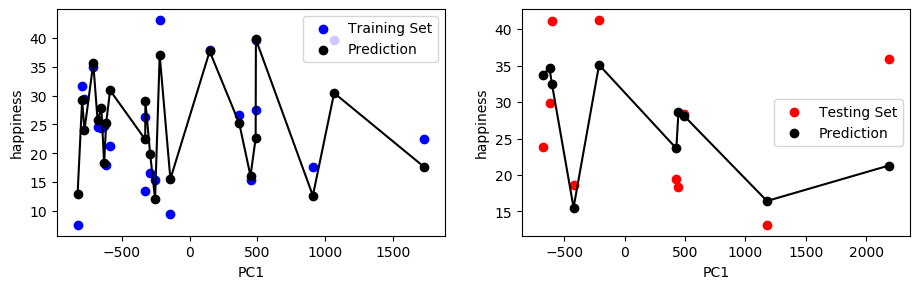

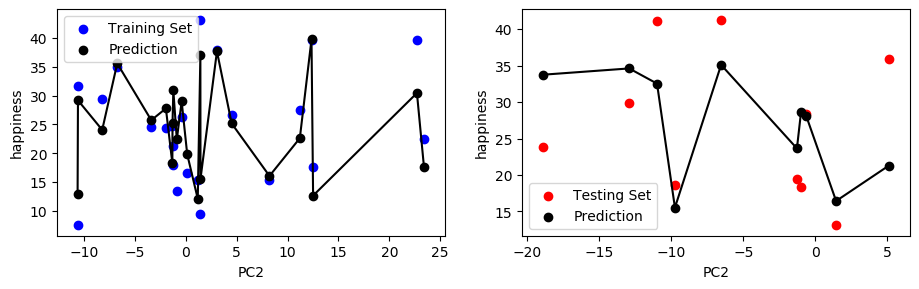

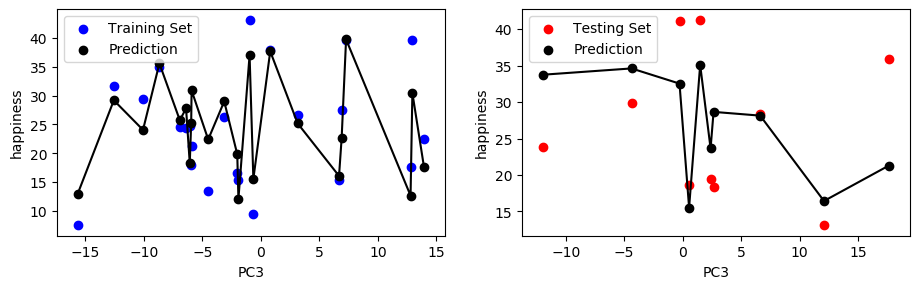

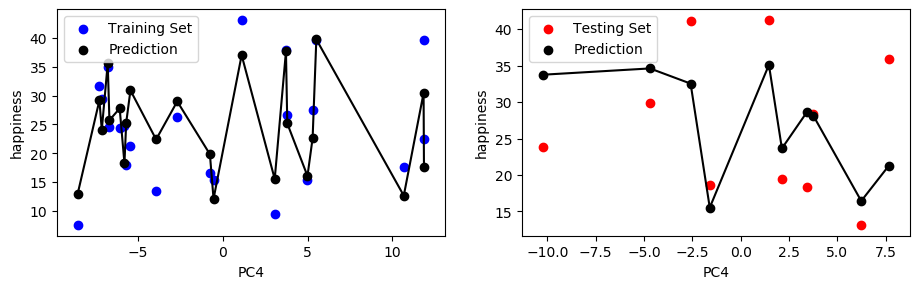

In [37]:
reg_pc(Lasso())